Reading in packages that will we used later

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [3]:
#Adjusting batch size to 32 and reducing img size from 180x180 to see if this improves model fitting performance
data_dir= "C:\\Users\\amanda.persson\\OneDrive - Accenture\\Private\\ASL images\\asl_alphabet_train\\asl_alphabet_train"
batch_size = 8
img_height = 120
img_width = 120



Reading all test data for later use

In [9]:
#Intentionally manipulated to provide less data for testing that model works
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels="inferred", 
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels="inferred",  
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Defining the model that will later be trained

In [6]:
num_classes = 29

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0

In [9]:
# Define a Callback class that stops training once accuracy reaches 99.0%
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
callback=myCallback()

In [10]:

annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [11]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback,annealer]  
)

Epoch 1/10
8700/8700 [==============================] - 1495s 163ms/step - loss: 1.2426 - accuracy: 0.6308 - val_loss: 0.1335 - val_accuracy: 0.9566
Epoch 2/10
8700/8700 [==============================] - 807s 93ms/step - loss: 0.0776 - accuracy: 0.9747 - val_loss: 0.0894 - val_accuracy: 0.9695
Epoch 3/10
8700/8700 [==============================] - 763s 88ms/step - loss: 0.0453 - accuracy: 0.9861 - val_loss: 0.0743 - val_accuracy: 0.9795
Epoch 4/10
8700/8700 [==============================] - 759s 87ms/step - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0176 - val_accuracy: 0.9940
Epoch 5/10
8700/8700 [==============================] - 779s 90ms/step - loss: 0.0207 - accuracy: 0.9939 - val_loss: 0.0183 - val_accuracy: 0.9948
Epoch 6/10
8700/8700 [==============================] - 787s 90ms/step - loss: 0.0193 - accuracy: 0.9951 - val_loss: 0.0142 - val_accuracy: 0.9960
Epoch 7/10
8700/8700 [==============================] - 803s 92ms/step - loss: 0.0154 - accuracy: 0.9957 - val_loss:

Check accuracy of trained model

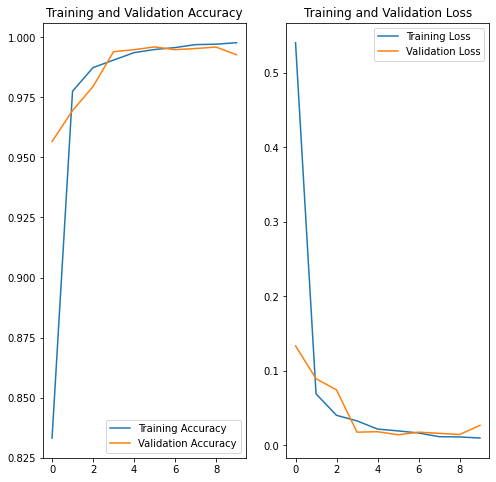

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model.save("3Convlayer_20210315_10epochs_custom_decay_rate")

INFO:tensorflow:Assets written to: 3Convlayer_20210315_10epochs_custom_decay_rate\assets


In [6]:
model = keras.models.load_model("3Convlayer_20210315_10epochs_custom_decay_rate")

In [12]:
test_url = "C:\\Users\\amanda.persson\\OneDrive - Accenture\\Private\\ASL images\\asl_alphabet_test\\asl_alphabet_test\\nothing_test.jpg"
img = keras.preprocessing.image.load_img(
    test_url, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to nothing with a 100.00 percent confidence.
